# Sparse coding and signal recovery

Here we'll look at the approximation and noisy deconvolution of signals with sparsity. We'll use samples from the LFW dataset as before.

In [7]:
import numpy as np
import scipy.fftpack as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import sparse_encode
from sklearn.datasets import fetch_lfw_people

num_images = 10000

lfw_people = fetch_lfw_people(resize=0.2)
indices = np.random.choice(len(lfw_people.images), num_images, replace=False)

images = -lfw_people.images[indices]
data = -lfw_people.data[indices]
mean = np.mean(data,axis=0)
data_centered = (data - mean)/128

this_index = 503
this_face = images[this_index]
this_data = data_centered[this_index]

height, width = this_face.shape
size = height*width

First, we'll generate dictionaries: the complete DCT dictionary and an overcomplete dictionary learned from the data.

In [2]:
#to get a 2-D basis, we find a basis for the rows and the columns and take the Kronecker product
W_1 = sp.dct(np.eye(height),type=2,norm='ortho')
W_2 = sp.dct(np.eye(width),type=2,norm='ortho')
W_DCT = np.kron(W_1,W_2)

#PCA features
pca = PCA()
pca.fit(data_centered)
W_PCA = pca.components_

In [3]:
dl = MiniBatchDictionaryLearning(n_components=size*3, alpha=1)
W_OC = dl.fit(data_centered).components_

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.350e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.350e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.675e-03, with an active set of 5 regressors, and the smallest cholesky pivot element bei

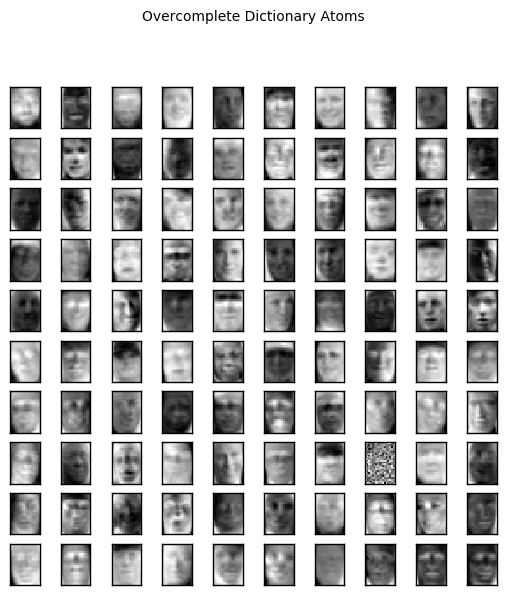

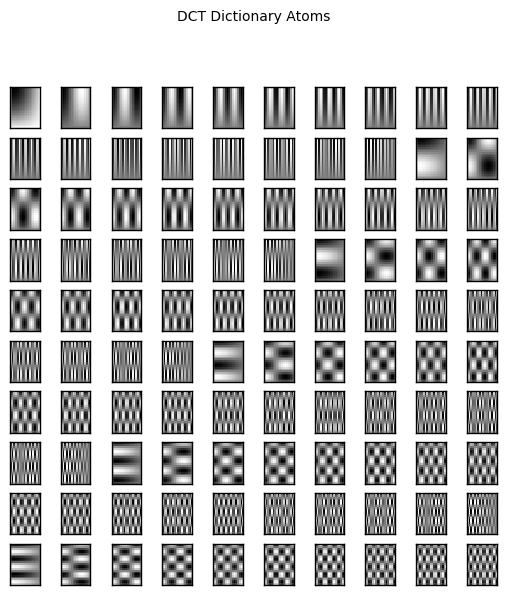

In [4]:
#plt.matshow(np.resize(W_DCT[:,500],(height,width)))
#plt.show()
plt.figure(figsize=(6, 6))
for i, comp in enumerate(W_OC[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((height,width)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Overcomplete Dictionary Atoms')
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

plt.figure(figsize=(6, 6))
for i, comp in enumerate(W_DCT[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((height,width)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('DCT Dictionary Atoms')
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

Now that we have the dictionaries, let's try encoding the image. We'll try both the usual PCA encoding, sparse coding using the DCT basis, and sparse coding using the overcomplete basis.

In [8]:
k = 50

this_data_PCA = W_PCA[:k].T@W_PCA[:k]@this_data

DCT_coeffs = sparse_encode(np.reshape(this_data,(1,-1)),W_DCT,n_nonzero_coefs=k,algorithm='lars')
this_data_DCT = DCT_coeffs@W_DCT

OC_coeffs = sparse_encode(np.reshape(this_data,(1,-1)),W_OC,n_nonzero_coefs=k,algorithm='lars')
this_data_OC = OC_coeffs@W_OC

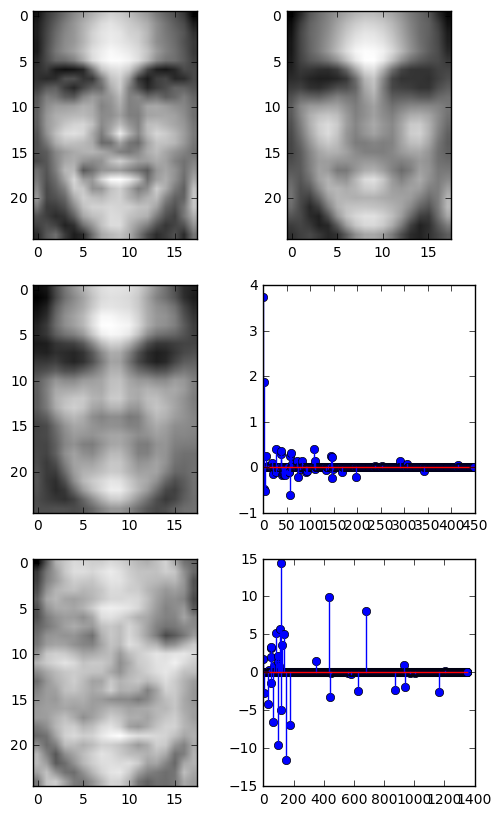

In [9]:
plt.figure(figsize=(6,10))

plt.subplot(3, 2, 1)
plt.imshow(this_face, cmap=plt.cm.gray_r)

plt.subplot(3,2,2)
plt.imshow(np.reshape(this_data_PCA+mean/128,(height,width)), cmap=plt.cm.gray_r)

plt.subplot(3,2,3)
plt.imshow(np.reshape(this_data_DCT+mean/128,(height,width)), cmap=plt.cm.gray_r)

plt.subplot(3,2,4)
plt.stem(DCT_coeffs.flatten())

plt.subplot(3,2,5)
plt.imshow(np.reshape(this_data_OC+mean/128,(height,width)), cmap=plt.cm.gray_r)

plt.subplot(3,2,6)
plt.stem(OC_coeffs.flatten())
plt.show()

## Signal recovery via sparse coding

Now we'll try recovering the sparse coefficients of a corrupted version of our image.

In [12]:
sigma_2 = 0.01
num_measurements = 200
H = np.random.randn(num_measurements,size)#np.diag(h)

y = H@this_data + np.sqrt(sigma_2)*np.random.randn(num_measurements)
y_image = np.reshape(y,(height,-1))

#Perform "LASSO" using the transformed dictionary
c_DCT = sparse_encode(np.reshape(y,(1,-1)),W_DCT@H.T)
c_OC = sparse_encode(np.reshape(y,(1,-1)),W_OC@H.T)

reconstructed_DCT = c_DCT@W_DCT
reconstructed_OC = c_OC@W_OC

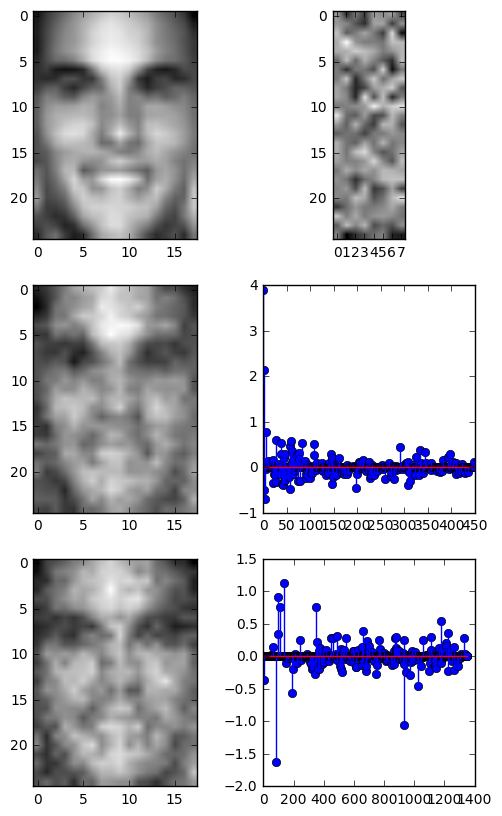

In [13]:
plt.figure(figsize=(6,10))

plt.subplot(3, 2, 1)
plt.imshow(this_face, cmap=plt.cm.gray_r)

plt.subplot(3,2,2)
plt.imshow(y_image, cmap=plt.cm.gray_r)

plt.subplot(3,2,3)
plt.imshow(np.reshape(reconstructed_DCT+mean/128,(height,width)), cmap=plt.cm.gray_r)

plt.subplot(3,2,4)
plt.stem(c_DCT.flatten())

plt.subplot(3,2,5)
plt.imshow(np.reshape(reconstructed_OC+mean/128,(height,width)), cmap=plt.cm.gray_r)

plt.subplot(3,2,6)
plt.stem(c_OC.flatten())
plt.show()